In [3]:
from pyspark.sql import SparkSession
spark=SparkSession.builder\
.appName("Movie RATINGS-ANALYSIS")\
.getOrCreate()
spark

csv_data="""
MovieID,Title,Genre,ReleaseDate,Rating,Revenue,Budget
1,Inception,Sci-Fi,2010-07-16,8.8,825532764,160000000
2,The Dark Knight,Action,2008-07-18,9.0,1004558444,185000000
3,Titanic,Romance,1997-12-19,7.8,2187463944,200000000
4,Interstellar,Sci-Fi,2014-11-07,8.6,677471339,165000000
5,Joker,Drama,2019-10-04,8.4,1074251311,55000000
6,The Notebook,Romance,2004-06-25,7.9,,29000000
7,Avengers: Endgame,Action,2019-04-26,8.4,2797800564,356000000"""
with open("movies.csv",'w')as f:
  f.write(csv_data)

In [16]:
print('----------------------PART 1: Pandas Operations------------------')

----------------------PART 1: Pandas Operations------------------


---------------------------------------
---------------------------------------
   MovieID              Title    Genre ReleaseDate  Rating       Revenue  \
0        1          Inception   Sci-Fi  2010-07-16     8.8  8.255328e+08   
1        2    The Dark Knight   Action  2008-07-18     9.0  1.004558e+09   
2        3            Titanic  Romance  1997-12-19     7.8  2.187464e+09   
3        4       Interstellar   Sci-Fi  2014-11-07     8.6  6.774713e+08   
4        5              Joker    Drama  2019-10-04     8.4  1.074251e+09   
5        6       The Notebook  Romance  2004-06-25     7.9           NaN   
6        7  Avengers: Endgame   Action  2019-04-26     8.4  2.797801e+09   

     Budget         Profit  
0  160000000  6.655328e+08  
1  185000000  8.195584e+08  
2  200000000  1.987464e+09  
3  165000000  5.124713e+08  
4   55000000  1.019251e+09  
5   29000000           NaN  
6  356000000  2.441801e+09  
---------------------------------------
   MovieID              Title    Genre 

<Figure size 1000x600 with 0 Axes>

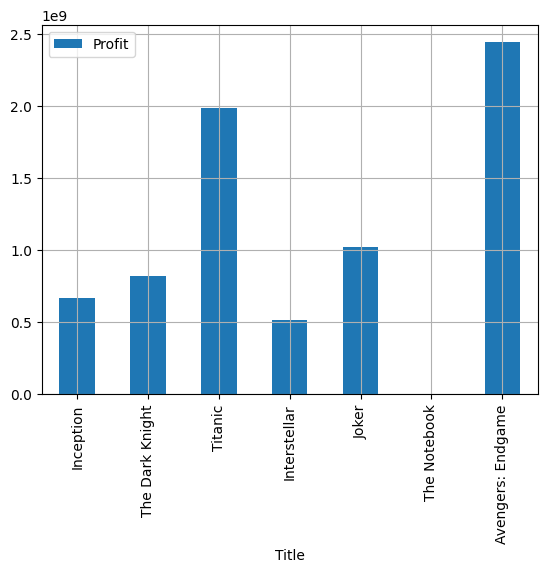

In [33]:
import pandas as pd
from datetime import datetime
df=pd.read_csv("movies.csv")
print("---------------------------------------")

df['ReleaseDate']=pd.to_datetime(df['ReleaseDate'])



print("---------------------------------------")

df['Profit']=df['Revenue']-df['Budget ']
print(df)

print("---------------------------------------")
def assignera(year):
  if year<2000:
    return("Classic")
  elif year>=2000 and year<2010:
    return("Modern")
  else:
    return("Modern")
df['Era']=df["ReleaseDate"].dt.year.map(assignera)
print(df)
print("---------------------------------------")
df['Revenue']=df['Revenue'].fillna(df['Revenue'].mean())
print(df)
print("------------------------------------------")

df_sorted=df.sort_values(by="Rating",ascending=False)
print(df_sorted)

print("------------------------------------------")

df_grouped=df.groupby("Genre").agg({"Rating":"mean","Revenue":"sum"})
print(df_grouped)


print("------------------------------------------")
filtered=df[((df["Rating"]>=8.5)&(df["Profit"]>500000000))]
print(filtered)

print("------------------------------------------")
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))

df.plot(kind="bar",x="Title",y="Profit")
plt.grid(True)
plt.show()


In [36]:
print("-------------------------------- PART 2: PySpark Operations-----------")


-------------------------------- PART 2: PySpark Operations-----------


In [65]:
from pyspark.sql.functions import col,avg,sum,when,year,month
from pyspark.sql.window import Window
from pyspark.sql.functions import rank
pf=spark.read.csv("movies.csv",header=True,inferSchema=True)
pf.show()
print("----------------------------------------------")

pf=pf.withColumn("Profit",col("Revenue")-col("Budget "))
pf.show()
print("-----------------------------------------------")

filtered_pf=pf.filter((col("Genre")=="Sci-Fi")&(col("Profit")>500000000))
filtered_pf.show()
print("-----------------------------------------------")

pf_grouped=pf.groupBy("Genre").agg(avg(col("Rating")).alias("Avg_Rating"),sum(col("Profit")).alias("Total_profit"))
pf_grouped.show()

print("-----------------------------------------------")

pf=pf.withColumn("RatingClassify",when(col("Rating")>9,"Blockbuster").when(col("Rating")>=8,"Hit").otherwise("Average"))
pf.show()

print("-----------------------------------------------")


pf=pf.drop(col("Budget "))
pf.show()

print("-----------------------------------------------")

avg_rev = pf.agg(avg('Revenue')).first()[0]

pf=pf.na.fill({"Revenue":avg_rev})
pf.show()

print("-----------------------------------------------")
pf=pf.withColumn("ReleaseDate",col("ReleaseDate").cast("date"))

pf=pf.withColumn("Year",year(col("ReleaseDate"))).withColumn("Month",month(col("ReleaseDate")))
pf.show()
print("----------------------------------------------------")
window_spec=Window.partitionBy("Genre").orderBy(col("Profit").desc())
pf=pf.withColumn("ProfitRank",rank().over(window_spec))
pf.show()




+-------+-----------------+-------+-----------+------+----------+---------+
|MovieID|            Title|  Genre|ReleaseDate|Rating|   Revenue|  Budget |
+-------+-----------------+-------+-----------+------+----------+---------+
|      1|        Inception| Sci-Fi| 2010-07-16|   8.8| 825532764|160000000|
|      2|  The Dark Knight| Action| 2008-07-18|   9.0|1004558444|185000000|
|      3|          Titanic|Romance| 1997-12-19|   7.8|2187463944|200000000|
|      4|     Interstellar| Sci-Fi| 2014-11-07|   8.6| 677471339|165000000|
|      5|            Joker|  Drama| 2019-10-04|   8.4|1074251311| 55000000|
|      6|     The Notebook|Romance| 2004-06-25|   7.9|      NULL| 29000000|
|      7|Avengers: Endgame| Action| 2019-04-26|   8.4|2797800564|356000000|
+-------+-----------------+-------+-----------+------+----------+---------+

----------------------------------------------
+-------+-----------------+-------+-----------+------+----------+---------+----------+
|MovieID|            Title|  

In [66]:
print("------------------- PART 3: JSON + Union Example---------------------")

------------------- PART 3: JSON + Union Example---------------------


In [84]:
import json
json_data=[
    {"MovieID": 8, "Title": "Barbie", "Genre": "Drama", "Rating": 7.5, "Revenue": 1456000000, "Budget ": 145000000},
    {"MovieID": 9, "Title": "Oppenheimer", "Genre": "Drama", "Rating": 8.6, "Revenue": 950000000, "Budget ": 100000000}
]
with open("movies_bonus.json","w")as d:
  json.dump(json_data,d)

In [87]:
jf=spark.read.json("movies_bonus.json", multiLine=True)
jf.show()
pf=spark.read.csv("movies.csv",header=True,inferSchema=True)
pf.show()

print("------------------------------------")
all_movies=pf.unionByName(jf,allowMissingColumns=True)
all_movies.show()
print("---------------------------------------")
top_5=all_movies.orderBy(col("Revenue").desc()).show(5)
print("---------------------------------------")

all_movies.write.csv("all_movies_merged.csv",header=True)



+---------+-----+-------+------+----------+-----------+
|  Budget |Genre|MovieID|Rating|   Revenue|      Title|
+---------+-----+-------+------+----------+-----------+
|145000000|Drama|      8|   7.5|1456000000|     Barbie|
|100000000|Drama|      9|   8.6| 950000000|Oppenheimer|
+---------+-----+-------+------+----------+-----------+

+-------+-----------------+-------+-----------+------+----------+---------+
|MovieID|            Title|  Genre|ReleaseDate|Rating|   Revenue|  Budget |
+-------+-----------------+-------+-----------+------+----------+---------+
|      1|        Inception| Sci-Fi| 2010-07-16|   8.8| 825532764|160000000|
|      2|  The Dark Knight| Action| 2008-07-18|   9.0|1004558444|185000000|
|      3|          Titanic|Romance| 1997-12-19|   7.8|2187463944|200000000|
|      4|     Interstellar| Sci-Fi| 2014-11-07|   8.6| 677471339|165000000|
|      5|            Joker|  Drama| 2019-10-04|   8.4|1074251311| 55000000|
|      6|     The Notebook|Romance| 2004-06-25|   7.9| 

In [88]:
print("----------------Bonus tasks-----------------")


----------------Bonus tasks-----------------


+-------+-----------------+-------+-----------+------+----------+---------+----------+-----------------+
|MovieID|            Title|  Genre|ReleaseDate|Rating|   Revenue|  Budget |    Profit|              ROI|
+-------+-----------------+-------+-----------+------+----------+---------+----------+-----------------+
|      1|        Inception| Sci-Fi| 2010-07-16|   8.8| 825532764|160000000| 665532764|      4.159579775|
|      2|  The Dark Knight| Action| 2008-07-18|   9.0|1004558444|185000000| 819558444|4.430045643243243|
|      3|          Titanic|Romance| 1997-12-19|   7.8|2187463944|200000000|1987463944|       9.93731972|
|      4|     Interstellar| Sci-Fi| 2014-11-07|   8.6| 677471339|165000000| 512471339|3.105886903030303|
|      5|            Joker|  Drama| 2019-10-04|   8.4|1074251311| 55000000|1019251311|18.53184201818182|
|      6|     The Notebook|Romance| 2004-06-25|   7.9|      NULL| 29000000|      NULL|             NULL|
|      7|Avengers: Endgame| Action| 2019-04-26|   8.4|2

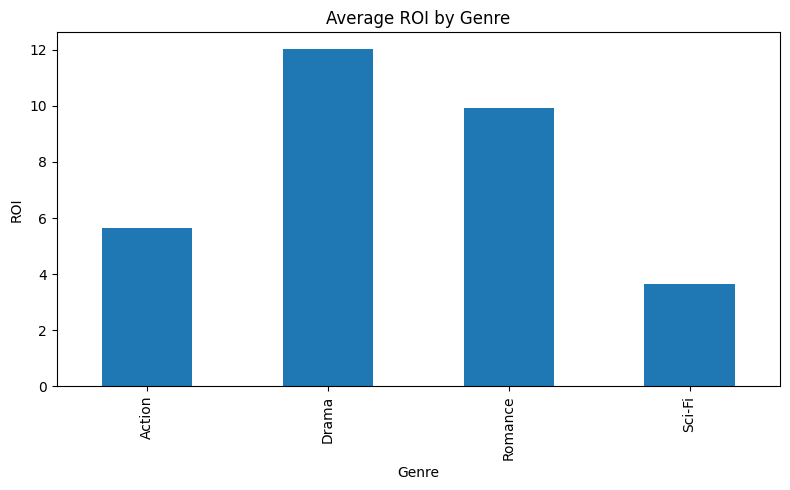

In [99]:

all_movies=all_movies.withColumn("Profit",col("Revenue")-col("Budget "))
all_movies=all_movies.withColumn("ROI",col("Profit")/col("Budget "))
all_movies.show()

print("----------------------------")
top_roi=all_movies.filter(col("Budget ")>50000000).orderBy("ROI",ascending=False).show(5)
print("----------------------------")

roi_pd = all_movies.toPandas().groupby('Genre')['ROI'].mean()
roi_pd.plot(kind='bar', figsize=(8,5), title='Average ROI by Genre')
plt.ylabel('ROI')
plt.tight_layout()
plt.show()
